<a href="https://colab.research.google.com/github/rimosoma/neural/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MACHINE LEARNING AND NEURAL NETWORKS, A.A. 2025/2026**

**COMPUTER LAB 3** - Principal component analysis

**Duration: 3 hours**

**Introduction:**

Hyperspectral images are images of the Earth acquired by satellites or aicrafts. Rather than having three R/G/B color channels, these images have a lot more “color” components obtained through a fine sampling of the wavelength spectrum (hence the name “hyper”-spectral). The
resulting 3-dimensional dataset has one image (spectral band or “color”) for every sampled wavelength, which represents the measured radiance from each pixel at that specific wavelength. Hyperspectral images are very useful for image analysis: for every pixel at a given spatial position, it is possible to extract a so-called spectral vector, i.e. the 1-dimensional vector of values assumed by that pixel at all wavelengths. Assuming that each pixel is composed of just one substance, the spectral vector represents the radiance of that substance at all the wavelengths that have been
sampled. Therefore, spectral vectors can be used to infer which substance is contained in a given pixel (this is a typical classification problem that has a lot of practical applications in agriculture, analysis of land use / land cover, and other applications related to the study of the environment).


In this lab you will use a real hyperspectral image that has been acquired by the AVIRIS instrument, an airborne hyperspectral imager operated by the NASA. The image represents a scene of Indian Pines (Indiana, USA). It has a size of 145x145 pixels and 220 spectral bands. Along with the image, a ground truth is available in terms of labels specifying which class (out of 16) each pixel belongs to. The classes are reported below; for more information, please see
http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Indian_Pines

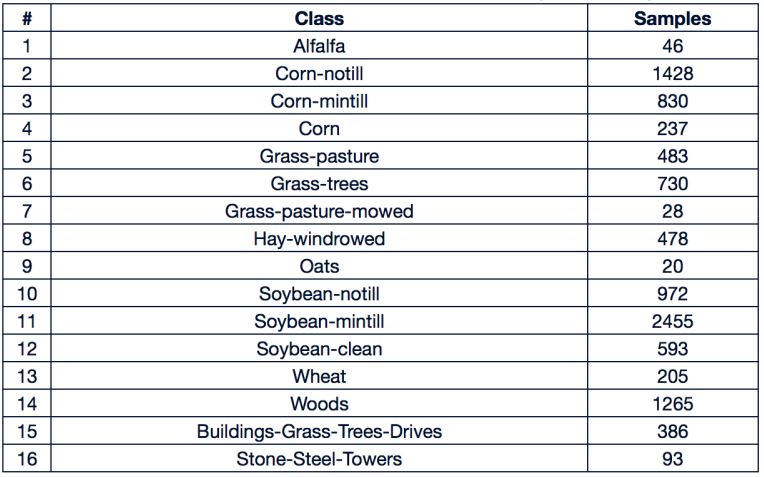

The purpose of this computer lab is twofold:
To apply PCA to the spectral vectors in order to reduce their dimensionality.

*   To apply PCA to the spectral vectors in order to reduce their dimensionality.
*   To perform classification on the reduced data (optional)

**Exercise 1 – PCA**


In this exercise, you will employ the Indian Pines dataset. You will not do this for the entire dataset, but only for the spectral vectors belonging to **two classes** (Note: also in the optional exercise you will perform 2-class classification on the PCA coefficients).

**Reminder:** the input to the PCA must always have zero mean: besides the sample covariance, you will have to compute the **mean value μ** over the training set and subtract it from each test vector before applying PCA.

**Task:** You have to reduce the dimensionality of the spectral vectors of the two classes you have chosen using PCA. In particular, you should perform the following:


*   Extract spectral vectors of two classes, as described above (see sample code below).
*   Estimate the sample covariance matrix of the dataset as a whole (i.e., considering together spectral vectors of the two classes)
*   Perform the eigenvector decomposition of the sample covariance matrix. You can use the numpy linalg.eig function, which outputs the matrix containing the eigenvectors as columns, and a diagonal matric containing the eigenvalues on the main diagonal.
  * Note: in the output matrix, eigenvectors/eigenvalues are not necessarily ordered by eigenvalue magnitude. You should sort them by yourself.
*   Choose a number of dimensions K<=220.
*   Construct the eigenvector matrix W for K components (i.e., select the last K columns)
*   Using W, compute the PCA coefficients for each spectral vector in the data set
*   Then from the PCA coefficients obtain an approximation of the corresponding vector and compute the error (mean square error - MSE)
*   Plot the average MSE over the test set as a function of K.
*   Plot the eigenvectors corresponding to the 3 largest eigenvalues – this will give you an idea of the basis functions employed by PCA

In [3]:
import numpy as np
import h5py
import scipy.io

#Prima di tutto salvo in un np.array i dati contenuti nel Indian_pines.mat,
#ovvero i dati veri e propri: per ciascun pixel sono contenute 220 features
#corrispondenti alle 220 spectral bands(immaginare un sudoku in cui, in ogni
#posizione(pixe) è presente un array di 220 dimensioni che descrive quel pixel)
mat = scipy.io.loadmat('Indian_pines.mat')
indian_pines = np.array(mat['indian_pines'])

#poi estraggo in un altro np.array i dati contenuti nel Indian_pines_gt.mat,
#ovvero i dati ground truth: per ogni pixel è memorizzato solo 1 numero: la
#vera classe di appartenenza(immaginare un sudoku piatto)
mat = scipy.io.loadmat('Indian_pines_gt.mat')
indian_pines_gt = np.array(mat['indian_pines_gt'])


**Extract spectral vectors of two classes, as described above (see sample code below).**

In [5]:
class0_value = 2
#NumPy: "Preparami un grande contenitore vuoto (una scatola) da 3000 posti.
#Non so quanti me ne serviranno, ma di sicuro meno di 3000. Man mano che trovo
#i pixel giusti, li metterò in questa scatola, uno dopo l'altro, partendo dal
#posto n=0, e ogni pixel dovrà contenere l'informazione di 220 spettri
#(il prof aveva inizializzato a 1500 ma ci sono classi con + di 1500 pixel)
class0=np.zeros((3000,220))
n=0
#ciclo su ogni pixel dell'immagine
for i in range(145):
  for j in range(145):
    #se il pixel appartiene alla classe desiderata(verifico con indian_pines_gt)
    if indian_pines_gt[i,j]== class0_value:
      #inserisco il pixel nella posizione n-esima della scatola creata inizialmente
      #prendendo i 220 spettri dal indian_pines sfruttando la stessa posizione
      #(indicizzazione) del pixel nei due files
      #questa notazione infatti dice: "sulla riga n della scatola, usa tutte
      #le colonne (220)inserendo cio che è contenuto all'indice i,j di i
      #ndian_pines, che sarà un array proprio di 220 dimensioni"
      class0[n,:] = indian_pines[i,j,:]/1.
      n=n+1
#quest'ultimo comando serve a tagliare la scatola iniziale secondo lo spazio
#effettivamente usato
class0=class0[:n,:]



#ripeto tutto quanto per un'altra classe, ottenendo la seconda matrice(scatola),

class1_value = 11

class1=np.zeros((3000,220))
n=0
for i in range(145):
  for j in range(145):
    if indian_pines_gt[i,j]== class1_value:
      class1[n,:] = indian_pines[i,j,:]/1.
      n=n+1
class1=class1[:n,:]

**Estimate the sample covariance matrix of the dataset as a whole (i.e., considering together spectral vectors of the two classes)**

In [7]:
#Unisco le 2 matrici ottenendo quindi un elenco di righe da 220 dimensioni
#in cui sono elencate gli spettri di tutti i pixel appartenenti alle 2 classi
X_two_classes = np.concatenate((class0, class1), axis=0)

#RICHIESTO
#(sottrarre la media): Perché la PCA cerca le direzioni di
#massima varianza, e la varianza è definita attorno alla media.
#Senza centratura, il primo asse che la PCA troverebbe non sarebbe la
#direzione di massima varianza, ma semplicemente la direzione in cui i
#dati sono "lontani" dall'origine (0,0).

#NON RICHIESTO
#(dividere per st. dev.): Perché la PCA è "sensibile" alla scala.
# Se una banda (feature) ha valori molto grandi (es. 0-10000) e
#un'altra ha valori piccoli (es. 0-1), la PCA si concentrerà solo sulla prima,
#ignorando l'informazione della seconda. Normalizzando, tutte le bande sono
#"sullo stesso piano" e dai a tutte la stessa importanza iniziale.

mu = np.mean(X_two_classes, axis=0)
std = np.std(X_two_classes, axis=0)

X_centered = X_two_classes - mu
X_normalized = X_centered / std


#calcolo la matrice di covarianza della centrata o normalizzata:
covariance_matrix_centr = np.cov(X_two_classes.T)
#covariance_matrix_norm = np.cov(X_normalized.T)

**Perform the eigenvector decomposition of the sample covariance matrix. You can use the numpy linalg.eig function, which outputs the matrix containing the eigenvectors as columns, and a diagonal matric containing the eigenvalues on the main diagonal.**

In [10]:
from numpy import linalg as LA

vettore_1D_autovalori, lista_autovettori = LA.eig(covariance_matrix_centr)

#Note: in the output matrix, eigenvectors/eigenvalues are not necessarily
#ordered by eigenvalue magnitude. You should sort them first.

#Nella PCA infatti si vuole:
#Ordinamento: Trovare gli autovalori (che sono numeri) e ordinarli dal più
  #grande al più piccolo.
#Riferimento: Si usa quest'ordine per "riordinare" gli
  # autovettori (che sono vettori). L'autovettore che corrispondeva all'autovalore
  #più grande diventa la tua prima colonna di W, e così via.
#Costruzione di W: La matrice W è costruita solo con gli autovettori (che sono
  #le "nuove direzioni"). L'autovalore è servito solo per sapere quali
  #autovettori erano i più importanti (quelli che "spiegano" più varianza).

#ordino quindi gli autovettori usando come parametro i corrispondenti autovalori,
#sfruttando argsort che mi restituisce le posizioni:
autovet_ord = lista_autovettori[:, vettore_1D_autovalori.argsort()[::-1]]

#autovet_ord è quindi semplicemente la matrice intera contenente come colonne
#tutti gli autovettori, non resta che spezzarla ad L colonne per ottenere W


**Choose a number of dimensions K<=220.Construct the eigenvector  matrix W for K components (i.e., select the last K columns)**

In [11]:
#Qui devo scegliere il numero K di dimensioni a cui voglio ridurre i pixel dalle
# 220 dimensioni iniziali ma poiche dopo viene richiesto di effettuare un plot
#in funzione di K, forse conviene creare una funzione richiamabile che lavora
#sulla matrice completa degli autovettori e estrae le prime k colonne

def extracting_W(k):
  return autovet_ord[:, :k]

**Using W, compute the PCA coefficients for each spectral vector in the data set. Then from the PCA coefficients obtain an approximation of the corresponding vector and compute the error (mean square error - MSE)**

In [13]:
#Note: remember to remove the mean from the vectors of the dataset

import matplotlib.pyplot as plt

# --- Preparazione del Ciclo ---
K_values = np.arange(1, 221)  # Cicliamo per K da 1 a 220
mse_errors = [] # Lista per salvare l'errore ad ogni K


print("Inizio ciclo per K da 1 a 220...")

# --- Esecuzione del Ciclo, cioè pr ogni valore di k calcolo la W corrispondente
# e determino la proiezione Z e la xhat ricostruita partendo dallo spazio a meno
#dimensioni, calcolando poi la differenza rispetto al valore originale ---
for K in K_values:

    # Ottieni la matrice W per il K corrente
    W_K = extracting_W(K)

    #  Calcolo dei Coefficienti PCA (Proiezione)
    Z_coeff = X_normalized @ W_K

    # Ricostruzione del Vettore (Approssimazione)
    X_hat_norm = Z_coeff @ W_K.T

    # Calcolo dell'Errore (MSE)
    mse = np.mean((X_normalized - X_hat_norm)**2)

    # Salva l'errore per questo K
    mse_errors.append(mse)

print("Ciclo completato.")



Inizio ciclo per K da 1 a 220...
Ciclo completato.


**Plot the average MSE over the test set as a function of K.**

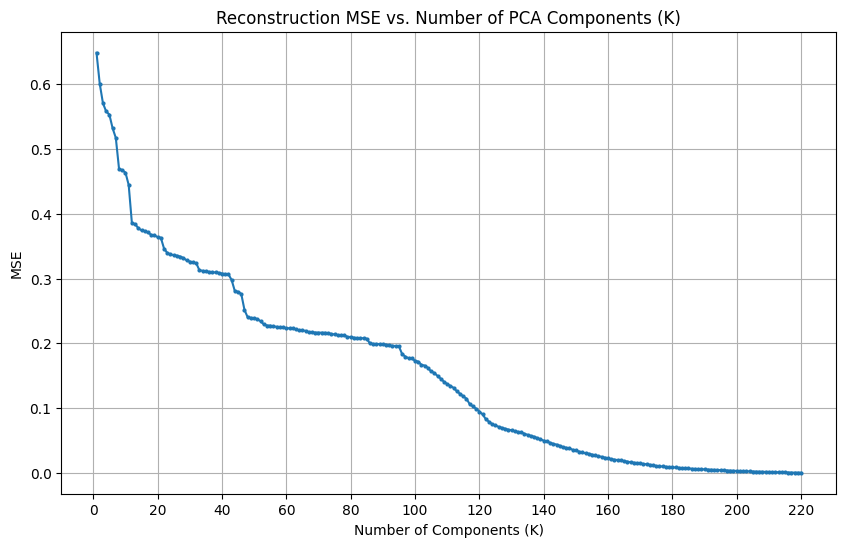

In [17]:
#  Risultato: Plot dell'MSE
# (Questo plot è il risultato del ciclo poichè associa l'errore corrispondente
#ai vari livelli di sottodimensionamento)
plt.figure(figsize=(10, 6))
plt.plot(K_values, mse_errors, marker='o', linestyle='-', markersize=2)
plt.title('Reconstruction MSE vs. Number of PCA Components (K)')
plt.xlabel('Number of Components (K)')
plt.ylabel('MSE')
plt.grid(True)
plt.xticks(np.arange(0, 221, 20))
plt.show() # Mostra l'immagine

**Plot the eigenvectors corresponding to the 3 largest eigenvalues – this will give you an idea of the basis functions employed by PCA**

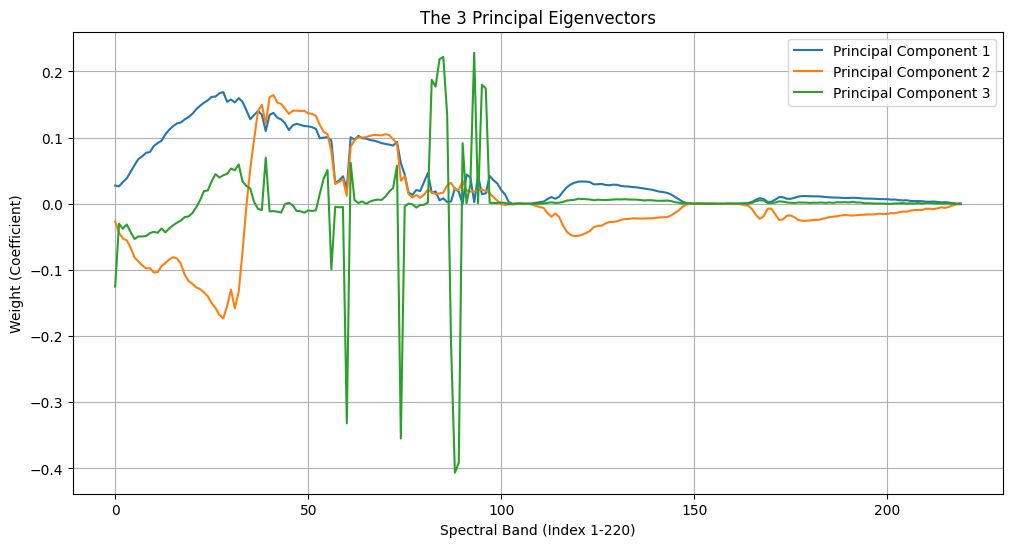

In [19]:
#  Plot dei 3 Autovettori Principali
plt.figure(figsize=(12, 6))

# Estrae la colonna 0 (Autovettore 1)
plt.plot(autovet_ord[:, 0], label='Principal Component 1')

# Estrae la colonna 1 (Autovettore 2)
plt.plot(autovet_ord[:, 1], label='Principal Component 2')

# Estrae la colonna 2 (Autovettore 3)
plt.plot(autovet_ord[:, 2], label='Principal Component 3')

plt.title('The 3 Principal Eigenvectors')
plt.xlabel('Spectral Band (Index 1-220)')
plt.ylabel('Weight (Coefficient)')
plt.legend()
plt.grid(True)
plt.show()


**Student's comments to Exercise 1**

*Add comments to the results of Exercise 1 here (you may use LateX for formulas if needed).*

**Exercise 2 – Classification using dimensionality reduction and whitening (optional)**

In this exercise you will apply a simple 2-class linear discriminant analysis (LDA) classifier to the data belonging to the two classes, before and after **whitening** (i.e. applying PCA plus rescaling
each coefficient to unit variance: $y = \Lambda^{-\frac{1}{2}}W^{T}x$. Note that matrix $\Lambda$ is obtained as one of the outputs of *eig.m*). This classifier makes the Naïve Bayes Classifier assumption that the features are statistically independent, thus the shared covariance matrix is taken as $\Sigma = I$. We also assume that class 0 and class 1 are equiprobable. Thus, letting $\mu_{0}$ and $\mu_{1}$ be the mean of vectors in class 0 and 1, we define $x_{0} = 0.5(\mu_{0} + \mu_{1})$ and $w = \mu_{1}-\mu_{0}$. A test vector $x$ is classified into class 1 or 0 depending on whether $sign(w^{T}(x − x_{0}))$ is equal to +1 or -1.

When the classifier is applied to the PCA coefficients, you can simply replace $\mu_{0}$ and $\mu_{1}$ with their reduced versions (subtracting $\mu$ and applying the same PCA matrix computed over the training set), and recalculate $x_{0}$ and $w$ accordingly.

**Task:** Divide the Indian Pines dataset into training and test sets (e.g. 75% of the data of each class to be used as training data, and 25% as test data). Train this classifier on the training data, and
apply it to the test data. In particular, you should perform the following:
*   Plot the mean vector of class 0 and 1 – this will give you a visual description of the differences among vectors of either class.
*   Apply the classifier to the original data (without PCA) and compute its accuracy
*   Apply the classifier to the PCA coefficients for different values of K, and compute its accuracy
*   Apply the classifier to the original data where only the first K features have been retained, and compute its accuracy (this is a more brutal way to reduce dimensionality)
*   Try to classify the data using a Support Vector Machine and compare the results





**Plot the mean vector of class 0 and 1 – this will give you a visual description of the differences among vectors of either class.**

In [ ]:
#Insert code here

**Apply the classifier to the original data (without PCA) and compute
its accuracy**

In [ ]:
#For this section you can use the code you developed for the previous Lab or the sklearn function LinearDiscriminantAnalysis

**Apply the classifier to the PCA coefficients for different values of K, and compute its accuracy**

In [ ]:
#Insert code Here

**Apply the classifier to the original data where only a subset of K features (selected randomly) have been retained, and compute its accuracy (this is a more brutal way to reduce dimensionality)**

In [ ]:
#Insert code here

**Try to classify the data using a Support Vector Machine and compare the results**

In [ ]:
#For this section you can use the sklearn library

#from sklearn import svm

#svc = svm.SVC()
#svc.fit(Train, Train_Label)
#predict = svc.predict(Test)

#print(metrics.accuracy_score(predict, Test_Label))

**Student's comments to Exercise 2**

*Add comments to the results of Exercise 2 here (may use LateX for formulas if needed).*